In [1]:
import pandas as pd
import torch 
import torch.nn as nn
import os
import numpy as np
from sklearn import metrics
from sklearn.metrics import log_loss,roc_auc_score
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.pipeline import Pipeline
from torch.nn.init import constant_,normal_,xavier_normal_
from torch.optim import Adam
import matplotlib 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from itertools import permutations
from copy import deepcopy
from tqdm import tqdm
import seaborn as sns


import warnings
warnings.filterwarnings('ignore')

D:\ana\envs\pytorch1.7\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class RecData():
    def __init__(self):
        self.train_path_name = os.path.join(os.path.abspath(''),'train.csv')
        self.test_path_name = os.path.join(os.path.abspath(''),'test.csv')
        self.train_df = pd.read_csv(self.train_path_name)
        self.test_df = pd.read_csv(self.test_path_name)
        self.device = torch.device('cpu')
    def to(self,device):
        self.device = device
    def data_info(self)->None:
        '''
        打印数据基本信息
        '''
        print('''-------------train_df info-------------''')
        print(self.train_df.info())
        print('---------------test_df info---------------''')
        print(self.test_df.info())
        
    def data_null_dict(self)->dict:
        '''
        查看DataFrame的中每一列缺失数量
        '''
        return dict(self.train_df.isnull().sum()),dict(self.test_df.isnull().sum())
    def missing_values_table(self,df)->None:
        '''
        输出DataFrame缺失列名和确实数量
        '''
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mis_val_table = pd.concat([mis_val,mis_val_percent],axis = 1)
        mis_val_table_ren_columns = mis_val_table.rename(columns = {0:'Missing-Values',1:'% of total values'})
        self.mis_val_table_ren_columns = mis_val_table_ren_columns[mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of total values',ascending = False).round(1)
        
        print('Your selected dataframe has' + str(df.shape[1]) + 'columns.\n'
             'There are' + str(self.mis_val_table_ren_columns.shape[0]) + 'columns that have missing values.')
        return mis_val_table_ren_columns
    def fill_missing_value(self,df,mis_val_table_ren_columns)->None:
        '''
        填充缺失值
        '''
        mis_col = mis_val_table_ren_columns.index.to_list()
        print(mis_col)
        for col in mis_col:
            df[col].fillna(df[col].mode()[0],inplace = True)
    def trans_float_to_int(self,df)->None:
        '''
        将浮点类型转为整型
        '''
        for col in df.columns:
            if df[col].dtype is np.dtype('float64'):
                df[col] = df[col].astype('int64')
    def trans_time(self,df,col = 'date'):
        '''
        抽取时间特征中的 月份、日期、小时、星期
        '''
        df['date'] = df['date'].apply(lambda x:'2022-'+x)
        df['date'] = pd.to_datetime(df['date'])
        df['month'] = df['date'].dt.month
        df['day'] = df['date'].dt.day
        df['hour'] = df['date'].dt.hour
        df['weekday'] = df['date'].dt.weekday
    def trans_cate(self,df)->None:
        '''
        对catagory类的columns进行编码
        '''
        cols = list(df.select_dtypes('object').columns)
        for col in cols:
            label = LabelEncoder()
            df[col] = label.fit_transform(df[col])
    def plot_cols(self,df,cols)->None:
        '''
        可视化不同columns的分布
        '''
        plt.figure(figsize = (14,14))
        i = 0
        L = 3
        for col in cols:
            plt.subplot(L,L,i+1)
            if col != 'user_id':
                plt.xlabel(''.format(col))
                df[col].value_counts().plot(kind = 'bar')
                plt.legend()
            else:
                sns.distplot(df[col].value_counts(),kde = False)
                plt.legend()
            i += 1
        plt.show()
    def plot_col_click_rale(self,df,cols = ['hour','weekday','user_group_id'])->None:
        '''
        绘制相关列与label之间关系分布
        '''
        plt.figure(figsize = (10,10))
        i = 1
        for col in cols:
            plt.subplot(2,2,i)
            plt.title('{}_click_vis'.format(col))
            df.groupby(col)['isClick'].agg('count').plot(kind = 'bar')
            plt.legend(loc = 'best')
            i += 1
    def cate_and_click_relation(self,df)->None:
        '''
        输出相关列与label的点击次数均值
        '''
        categorical_cols = [col for col in list(df.select_dtypes('number').columns) if col != 'float' and col not in ['id','date','user_id','isClick']]
        for x in categorical_cols:
            print(df[[x,'isClick']].groupby(x,as_index = False).mean())
        return categorical_cols
    def get_corr(self,df,cate_cols)->None:
        '''
        计算各列与label之间的相关系数
        '''
        return df[['isClick'] + cate_cols].corr()
    def build_feature(self,df):
        '''
        特征构建，特征之间组合和转变
        '''
        df['click_counts'] = df.groupby('user_id')['user_id'].transform('count')
        df['user_class'] = df['click_counts'].apply(lambda x:1 if x > 3 else 0)
        
        def hint_click_rate(df,u_w,day_size):
            feat_name = '{}_hint_{}_clickrate'.format(u_w,day_size)
            df[feat_name] = 0
            first_day,last_day = df['day'].min(),df['day'].max()
            for i in range(first_day +1,last_day + 1):
                df_ = df.loc[(df['day'].values.astype(np.int64) >= i -day_size) & (df['day'].values.astype(np.int64) < i)]
                ind = (df['day'] == i)
                df.loc[ind,feat_name] = df.loc[ind,u_w].map(df_.groupby(u_w)['isClick'].mean())
            return df
        df = hint_click_rate(df,u_w = 'user_id',day_size = 3)
        df['user_web_id'] = df[['user_id','webpage_id']].apply(lambda x:str(x.user_id) + str(x.webpage_id),axis = 1)
        df = hint_click_rate(df,u_w = 'user_web_id',day_size = 3)
        
        df['user_product_3day_meanclick'] = df.groupby(['user_id','product','day'])['isClick'].transform(lambda x:x.rolling(3).mean().shift(1))
        df['user_product_3day_meanclick'].fillna(df['user_product_3day_meanclick'].mode(),inplace = True)
        
        
        df['act_hour'] = df['hour'].apply(lambda x:1 if x > 3 & x <= 22 else 0)
        
    
        df['user_group_id_act'] = df['user_group_id'].apply(lambda x:1 if x >= 1 & x < 5 else 0)
        
        cols_list = ['user_id','product','campaign_id','webpage_id','product_category_id','user_group_id','gender','age_level','user_depth','day','hour']
        
        for i in cols_list:
            df[i + 'cnt'] = df.groupby(i)['id'].transform('count')
        for j in list(permutations(cols_list,2)):
            df[j[0]+'_'+j[1]+'_cnt'] = df.groupby(list(j))['id'].transform('count')
        
        df['hour_timestamp'] = df.groupby(['user_id','day','hour'])['date'].transform(lambda x:(x.max() - x.min()).total_seconds())
        df['day_timestamp'] = df.groupby(['user_id','day'])['date'].transform(lambda x:(x.max() - x.min()).total_seconds())
        
        df['user_time_del'] = df.groupby(['user_id'])['date'].transform(lambda x:x.diff(periods = -1))
        df['user_time_del'] = df['user_time_del'].apply(lambda x:x.total_seconds())
        df.fillna(0,inplace = True)
        
        df['user_id_day_product_range'] = df.groupby(['user_id','day'])['product'].transform(lambda x:len(x)/np.array(range(1,len(x) +1)))
        df['user_campaign_webpage_range'] = df.groupby(['user_id','campaign_id'])['webpage_id'].transform(lambda x:len(x)/np.array(range(1,len(x)+ 1)))
        df['gender_age_product_user_time_mean'] = df.groupby(['gender','age_level','product_category_id'])['hour_timestamp'].transform('mean')
        
        for col in ['product','campaign_id','webpage_id','product_category_id']:
            df['day_'+col+'_nunique'] = df.groupby(['user_id','day'])[col].transform('nunique')
            df['day_'+col+'_nunique_per'] = df['day_' + col + '_nunique'] / df['user_id_day_cnt']
        df['day_hour_webpage_nunique'] = df.groupby(['user_id','day','hour'])['webpage_id'].transform('nunique')
    def select_features(self,df,no_features = ['id','isClick','date','user_id','product','campaign_id','webpage_id','user_group_id','age_level','hour','day','user_id_webpage_id'])->None:
        '''
        关键特征的选择
        '''
        features = [col for col in df.columns if col not in no_features]
        
        x_train = df[features]
        y_train = df['isClick']
        pipeline = Pipeline([('scaler',StandardScaler()),
                            ('model',Lasso())])
        search = GridSearchCV(pipeline,param_grid = {'model__alpha':[0.006,0.010,0.1]},cv = 3,scoring = 'neg_mean_squared_error',verbose = 3)
        search.fit(x_train,y_train)
        coef = search.best_estimator_.named_steps['model'].coef_
        importance = np.abs(coef)
        final_features = list(np.array(features)[importance > 0])
        return final_features
    def norm_col_value(self,df,cols)->None:
        '''
        特征数值归一化
        '''
        max_min_scaler = lambda x:(x-np.min(x)) / (np.max(x) - np.min(x))
        norm_cols = list(df[cols].select_dtypes('number').columns)
        for col in norm_cols:
            if col == 'isClick':
                continue
            df[col] = df[col].apply(max_min_scaler)
            df[col].fillna(0,inplace = True)
        return df
    def get_data_val(self,df,final_cols,train = True):
        '''
        获取选择特征后的训练数据和测试数据
        '''
        if train:
            self.train_value = df[final_cols + ['isClick']].values
        else:
            self.test_value = df[final_cols].values
    def train_valid_test_split(self,train_size = 0.8,valid_size = 0.1,test_size = 0.1,train = True):
        '''
        将数据转为torch的tensor
        '''
        if train:
            field_dims = (self.train_value.max(axis = 0).astype(int) + 1).tolist()[:-1]
            train,valid_test = train_test_split(self.train_value,train_size = train_size,random_state = 2022)
        else:
            field_dims = (self.test_value.max(axis = 0).astype(int) + 1).tolist()[:-1]
            train,test = train_test_split(self.test_value,train_size = valid_size,random_state = 2022)
        valid_size = valid_size / (test_size + valid_size)
        valid,test = train_test_split(valid_test,train_size = valid_size,random_state = 2022)
        device = self.device
        train_X = torch.tensor(train[:,:-1],dtype = torch.long).to(device)
        valid_X = torch.tensor(valid[:,:-1],dtype = torch.long).to(device)
        test_X = torch.tensor(test[:,:-1],dtype = torch.long).to(device)
        train_y = torch.tensor(train[:,-1],dtype = torch.float).unsqueeze(1).to(device)
        valid_y = torch.tensor(valid[:,-1],dtype = torch.float).unsqueeze(1).to(device)
        test_y = torch.tensor(test[:,-1],dtype = torch.float).unsqueeze(1).to(device)
        
        return field_dims,(train_X,train_y),(valid_X,valid_y),(test_X,test_y)
        

Your selected dataframe has13columns.
There are6columns that have missing values.
['id', 'date', 'user_id', 'product', 'campaign_id', 'webpage_id', 'product_category_id', 'user_group_id', 'gender', 'age_level', 'user_depth', 'var_1', 'isClick']


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


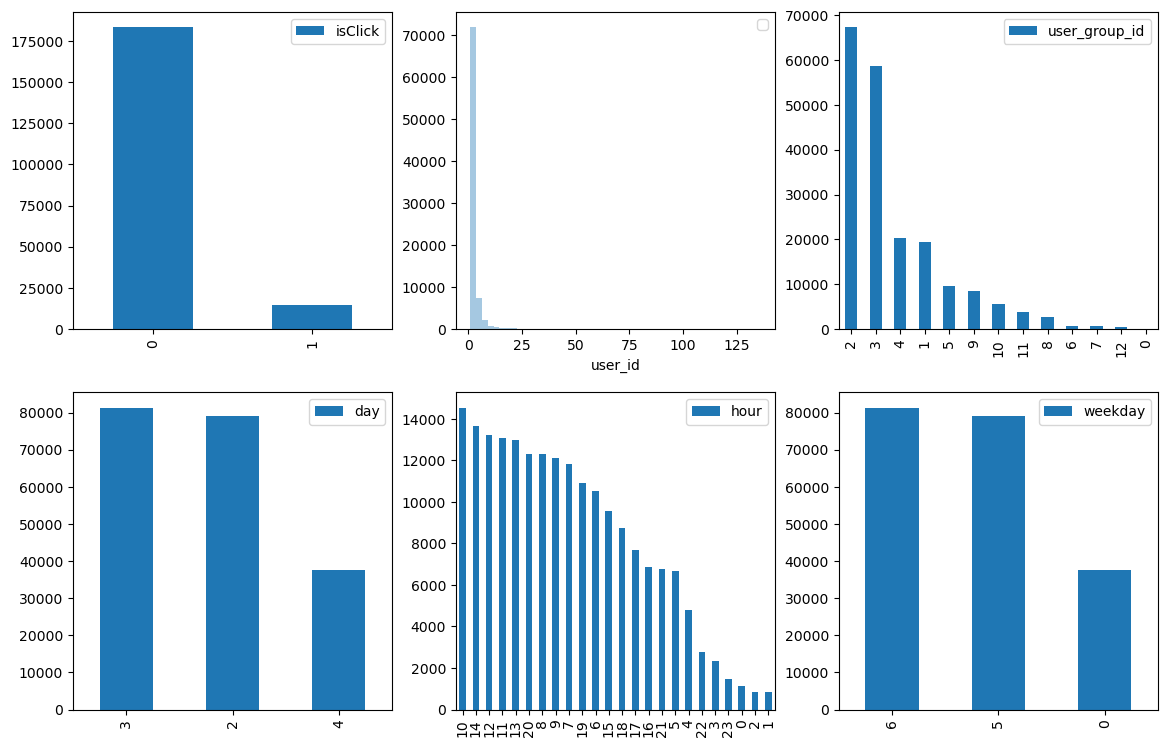

   product   isClick
0        0  0.080757
1        1  0.073499
2        2  0.052006
3        3  0.072886
4        4  0.055642
5        5  0.075683
6        6  0.047923
7        7  0.063673
8        8  0.092894
9        9  0.070442
   campaign_id   isClick
0            0  0.062725
1            1  0.066782
2            2  0.106867
3            3  0.049112
4            4  0.075296
5            5  0.077094
6            6  0.055827
7            7  0.060494
8            8  0.083948
   webpage_id   isClick
0           0  0.057953
1           1  0.066782
2           2  0.106867
3           3  0.075296
4           4  0.077094
5           5  0.055827
6           6  0.060494
7           7  0.083948
   product_category_id   isClick
0                    0  0.063929
1                    1  0.057861
2                    2  0.097143
3                    3  0.062593
4                    4  0.073942
    user_group_id   isClick
0               0  0.119048
1               1  0.084454
2               2  0.

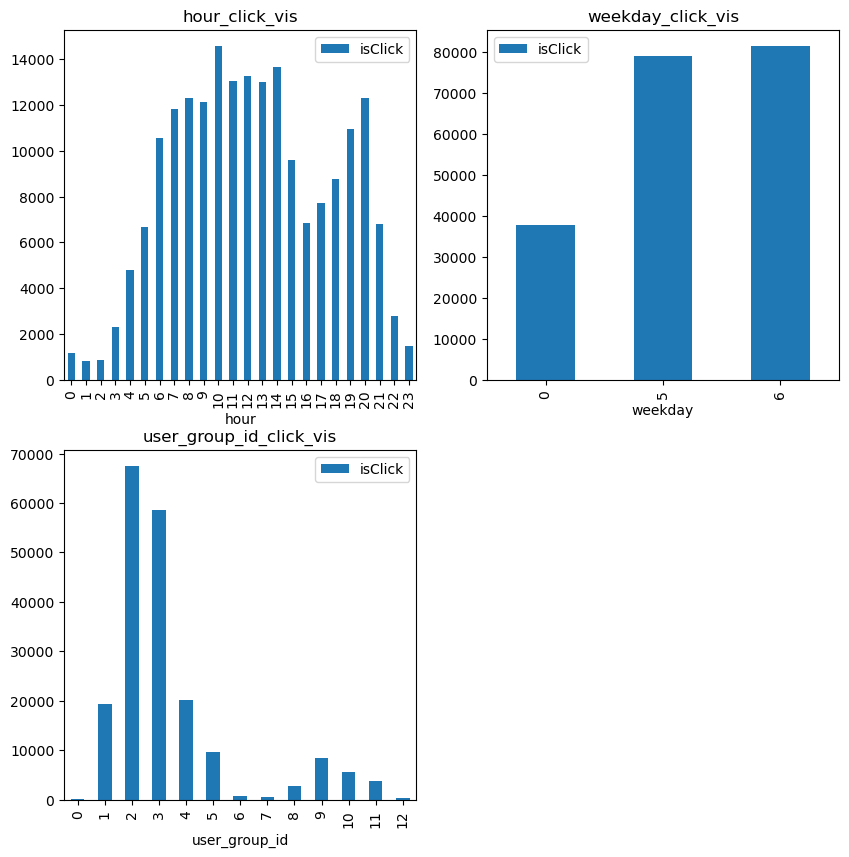

In [3]:
if __name__=='__main__':
    rd = RecData()
    rd.data_null_dict()
    tr_table = rd.missing_values_table(rd.train_df)
    rd.fill_missing_value(rd.train_df,tr_table)
    rd.trans_float_to_int(rd.train_df)
    rd.trans_time(rd.train_df)
    rd.trans_cate(rd.train_df)
    rd.plot_cols(rd.train_df,['isClick','user_id','user_group_id','day','hour','weekday'])
    rd.plot_col_click_rale(rd.train_df)
    tr_cate_cols = rd.cate_and_click_relation(rd.train_df)
    rd.get_corr(rd.train_df,tr_cate_cols)
    rd.build_feature(rd.train_df)
    tr_final_features = rd.select_features(rd.train_df)
    tr_final_features.append('isClick')
    rd.trans_cate(rd.train_df)
    rd.norm_col_value(rd.train_df,tr_final_features)
    rd.get_data_val(rd.train_df,tr_final_features)
    field_dims,(train_X,train_y),(valid_X,valid_y),(test_X,test_y) = rd.train_valid_test_split()

In [4]:
class CpuEmbedding(nn.Module):

    def __init__(self, num_embeddings, embed_dim):
        super(CpuEmbedding, self).__init__()

        self.weight = nn.Parameter(torch.zeros((num_embeddings, embed_dim)))
        nn.init.xavier_uniform_(self.weight.data)

    def forward(self, x):
        """
        :param x: shape (batch_size, num_fields)
        :return: shape (batch_size, num_fields, embedding_dim)
        """
        return self.weight[x]


class Embedding:

    def __new__(cls, num_embeddings, embed_dim):
        if torch.cuda.is_available():
            embedding = nn.Embedding(num_embeddings, embed_dim)
            nn.init.xavier_uniform_(embedding.weight.data)
            return embedding
        else:
            return CpuEmbedding(num_embeddings, embed_dim)


class FeaturesEmbedding(nn.Module):

    def __init__(self, field_dims, embed_dim):
        super(FeaturesEmbedding, self).__init__()
        self.embedding = Embedding(sum(field_dims), embed_dim)

        # e.g. field_dims = [2, 3, 4, 5], offsets = [0, 2, 5, 9]
        self.offsets = np.array((0, *np.cumsum(field_dims)[:-1]), dtype=np.long)

    def forward(self, x):
        """
        :param x: shape (batch_size, num_fields)
        :return: shape (batch_size, num_fields, embedding_dim)
        """
        x = x + x.new_tensor(self.offsets)
        return self.embedding(x)


class EmbeddingsInteraction(nn.Module):

    def __init__(self):
        super(EmbeddingsInteraction, self).__init__()

    def forward(self, x):
        """
        :param x: shape (batch_size, num_fields, embedding_dim)
        :return: shape (batch_size, num_fields*(num_fields)//2, embedding_dim)
        """

        num_fields = x.shape[1]
        i1, i2 = [], []
        for i in range(num_fields):
            for j in range(i + 1, num_fields):
                i1.append(i)
                i2.append(j)
        interaction = torch.mul(x[:, i1], x[:, i2])

        return interaction


class MultiLayerPerceptron(nn.Module):

    def __init__(self, layer, batch_norm=True):
        super(MultiLayerPerceptron, self).__init__()
        layers = []
        input_size = layer[0]
        for output_size in layer[1: -1]:
            layers.append(nn.Linear(input_size, output_size))
            if batch_norm:
                layers.append(nn.BatchNorm1d(output_size))
            layers.append(nn.ReLU())
            input_size = output_size
        layers.append(nn.Linear(input_size, layer[-1]))

        self.mlp = nn.Sequential(*layers)

    def forward(self, x):
        return self.mlp(x)
class CpuEmbedding(nn.Module):

    def __init__(self, num_embeddings, embed_dim):
        super(CpuEmbedding, self).__init__()

        self.weight = nn.Parameter(torch.zeros((num_embeddings, embed_dim)))
        nn.init.xavier_uniform_(self.weight.data)

    def forward(self, x):
        """
        :param x: shape (batch_size, num_fields)
        :return: shape (batch_size, num_fields, embedding_dim)
        """
        return self.weight[x]


class Embedding:

    def __new__(cls, num_embeddings, embed_dim):
        if torch.cuda.is_available():
            embedding = nn.Embedding(num_embeddings, embed_dim)
            nn.init.xavier_uniform_(embedding.weight.data)
            return embedding
        else:
            return CpuEmbedding(num_embeddings, embed_dim)


class FeaturesEmbedding(nn.Module):

    def __init__(self, field_dims, embed_dim):
        super(FeaturesEmbedding, self).__init__()
        self.embedding = Embedding(sum(field_dims), embed_dim)

        # e.g. field_dims = [2, 3, 4, 5], offsets = [0, 2, 5, 9]
        self.offsets = np.array((0, *np.cumsum(field_dims)[:-1]), dtype=np.long)

    def forward(self, x):
        """
        :param x: shape (batch_size, num_fields)
        :return: shape (batch_size, num_fields, embedding_dim)
        """
        x = x + x.new_tensor(self.offsets)
        return self.embedding(x)


class EmbeddingsInteraction(nn.Module):

    def __init__(self):
        super(EmbeddingsInteraction, self).__init__()

    def forward(self, x):
        """
        :param x: shape (batch_size, num_fields, embedding_dim)
        :return: shape (batch_size, num_fields*(num_fields)//2, embedding_dim)
        """

        num_fields = x.shape[1]
        i1, i2 = [], []
        for i in range(num_fields):
            for j in range(i + 1, num_fields):
                i1.append(i)
                i2.append(j)
        interaction = torch.mul(x[:, i1], x[:, i2])

        return interaction


class MultiLayerPerceptron(nn.Module):

    def __init__(self, layer, batch_norm=True):
        super(MultiLayerPerceptron, self).__init__()
        layers = []
        input_size = layer[0]
        for output_size in layer[1: -1]:
            layers.append(nn.Linear(input_size, output_size))
            if batch_norm:
                layers.append(nn.BatchNorm1d(output_size))
            layers.append(nn.ReLU())
            input_size = output_size
        layers.append(nn.Linear(input_size, layer[-1]))

        self.mlp = nn.Sequential(*layers)

    def forward(self, x):
        return self.mlp(x)

In [5]:
class EarlyStopper:

    def __init__(self, model, num_trials=50):
        self.num_trials = num_trials
        self.trial_counter = 0
        self.best_metric = -1e9
        self.best_state = deepcopy(model.state_dict())
        self.model = model

    def is_continuable(self, metric):
        # maximize metric
        if metric > self.best_metric:
            self.best_metric = metric
            self.trial_counter = 0
            self.best_state = deepcopy(self.model.state_dict())
            return True
        elif self.trial_counter + 1 < self.num_trials:
            self.trial_counter += 1
            return True
        else:
            return False


class BatchLoader:

    def __init__(self, X, y, batch_size=4096, shuffle=True):
        assert len(X) == len(y)

        self.batch_size = batch_size

        if shuffle:
            seq = list(range(len(X)))
            np.random.shuffle(seq)
            self.X = X[seq]
            self.y = y[seq]
        else:
            self.X = X
            self.y = y

    def __iter__(self):
        def iteration(X, y, batch_size):
            start = 0
            end = batch_size
            while start < len(X):
                yield X[start: end], y[start: end]
                start = end
                end += batch_size

        return iteration(self.X, self.y, self.batch_size)


class Trainer:

    def __init__(self, model, optimizer, criterion, batch_size=None, task='classification'):
        assert task in ['classification', 'regression']
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.batch_size = batch_size
        self.task = task

    def train(self, train_X, train_y, epoch=100, trials=None, valid_X=None, valid_y=None):
        if self.batch_size:
            train_loader = BatchLoader(train_X, train_y, self.batch_size)
        else:
            # 为了在 for b_x, b_y in train_loader 的时候统一
            train_loader = [[train_X, train_y]]

        if trials:
            early_stopper = EarlyStopper(self.model, trials)

        train_loss_list = []
        valid_loss_list = []

        for e in tqdm(range(epoch)):
            # train part
            self.model.train()
            train_loss_ = 0
            for b_x, b_y in train_loader:
                self.optimizer.zero_grad()
                pred_y = self.model(b_x)
                train_loss = self.criterion(pred_y, b_y)
                train_loss.backward()
                self.optimizer.step()

                train_loss_ += train_loss.detach() * len(b_x)

            train_loss_list.append(train_loss_ / len(train_X))

            # valid part
            if trials:
                valid_loss, valid_metric = self.test(valid_X, valid_y)
                valid_loss_list.append(valid_loss)
                if not early_stopper.is_continuable(valid_metric):
                    break

        if trials:
            self.model.load_state_dict(early_stopper.best_state)
            plt.plot(valid_loss_list, label='valid_loss')

        plt.plot(train_loss_list, label='train_loss')
        plt.legend()
        plt.show()

        print('train_loss: {:.5f} | train_metric: {:.5f}'.format(*self.test(train_X, train_y)))

        if trials:
            print('valid_loss: {:.5f} | valid_metric: {:.5f}'.format(*self.test(valid_X, valid_y)))

    def test(self, test_X, test_y):
        self.model.eval()
        with torch.no_grad():
            pred_y = self.model(test_X)
            test_loss = self.criterion(pred_y, test_y).detach()
        if self.task == 'classification':
            test_metric = metrics.roc_auc_score(test_y.cpu(), pred_y.cpu())
        elif self.task == 'regression':
            test_metric = -test_loss
        return test_loss, test_metric

In [6]:
class FactorizationMachine(nn.Module):
    
    def __init__(self, field_dims, embed_dim=4):
        super(FactorizationMachine, self).__init__()
        
        self.embed1 = FeaturesEmbedding(field_dims, 1)
        self.embed2 = FeaturesEmbedding(field_dims, embed_dim)
        self.bias = nn.Parameter(torch.zeros((1, )))
        
    def forward(self, x):
        # x shape: (batch_size, num_fields)
        # embed(x) shape: (batch_size, num_fields, embed_dim)
        square_sum = self.embed2(x).sum(dim=1).pow(2).sum(dim=1)
        sum_square = self.embed2(x).pow(2).sum(dim=1).sum(dim=1)
        output = self.embed1(x).squeeze(-1).sum(dim=1) + self.bias + (square_sum - sum_square) / 2
        output = torch.sigmoid(output).unsqueeze(-1)
        return output

In [7]:
class Config():
    def __init__(self):
        self.lr = 0.001
        self.dropout = 0.2
        self.batch_size = 512
        self.epochs = 10
        self.embedding_size = 10
        self.trail = 100
        self.regularization = 1e-6
args  = Config()

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:45<00:00,  4.51s/it]


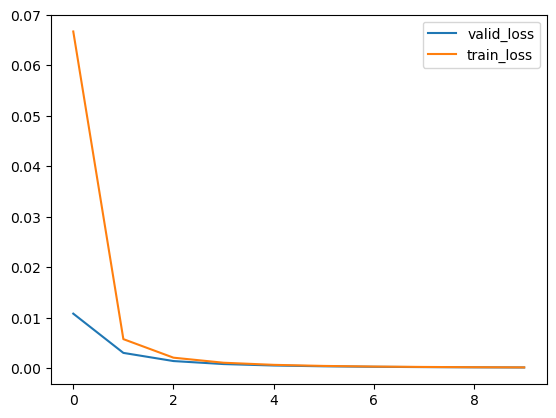

train_loss: 0.01083 | train_metric: 1.00000
valid_loss: 0.01078 | valid_metric: 1.00000
test_loss:  0.01088 | test_auc:  1.00000


In [8]:

device = torch.device('cude:0' if torch.cuda.is_available() else 'cpu')
wd = FactorizationMachine(field_dims, args.embedding_size).to(device)
optimizer = Adam(wd.parameters(), lr=args.lr, weight_decay=args.regularization)
criterion = nn.BCELoss()

trainer = Trainer(wd, optimizer, criterion, args.batch_size)
trainer.train(train_X, train_y, epoch=args.epochs, trials=args.trail, valid_X=valid_X, valid_y=valid_y)
test_loss, test_auc = trainer.test(test_X, test_y)
print('test_loss:  {:.5f} | test_auc:  {:.5f}'.format(test_loss, test_auc))